In [6]:
#%% Import necessary libraries
from glob import glob
from os import mkdir, remove
from os.path import exists, join, basename
from shutil import move, rmtree
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import pickle
import time

project_folder = '/data/custom/DeepNL/insareg/snapwf_02/'
data_folder = project_folder + 'data/'
graph_folder = project_folder + 'graphs/'
output_folder = project_folder + 'output/'
psi_output_folder = output_folder + 'psi/'
graph2run_folder = output_folder + 'graph2run/'
geo_folder = psi_output_folder + '01_geo/'
ifg_folder = psi_output_folder + '02_ifg/'
log_folder = output_folder + 'log/'

mk_folder =[output_folder, psi_output_folder, graph2run_folder, 
            geo_folder, ifg_folder, log_folder]

for i in mk_folder:
    if not exists(i):
        mkdir(i)

# Get the data files
data_files = glob(data_folder + '/*.zip')

######### Set the processing parameters #########
GPT = "/opt/snap/bin/gpt"
CACHE = '200G'
CPU = '20'
JVMemMax = '-Xmx200G'

one_graph = graph_folder + 'psi.xml'
one_graph2run = graph2run_folder + 'psi2run.xml'

######### Define function to run the graphs #########
def rungraph(graph, GPT, CACHE, CPU, JVMemMax, message=''):
    timeStarted = time.time()
    
    # Define the computing resources that will be used
    args = [GPT, '-J' + JVMemMax, graph, '-c', CACHE, '-q', CPU] 
    # args = [GPT, graph, '-c', CACHE, '-q', CPU]
    # args = [GPT, graph]
    
    # Launch the processing
    process = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    
    stdout = process.communicate()[0]
    print('SNAP STDOUT:{}'.format(stdout))
    print(process.returncode)
    timeDelta = time.time() - timeStarted

    print('Finished process in ' + str(timeDelta) + ' seconds.')
    print('Finished process in : {} seconds\n'.format(timeDelta))

    if process.returncode != 0:
        message = 'Error after {} sec!!!'.format(timeDelta) +  message + '.\n'
    else:
        message = 'Successfully completed in {} sec!!! '.format(timeDelta) + message + '.\n'
    
    return process.returncode, message

In [7]:
#%% Get the PSI interferometric pairs and the graph network
#% Read the stack from the ./data/stack.pkl file
with open(data_folder + 'stack.pkl', 'rb') as f:
    stack = pickle.load(f)

stack = stack[0]

data_psi_lst = []
for s in stack:
    file_stack = data_folder +  s.properties['fileID'][:-4] + '.zip'
    if file_stack in data_files:
        data_psi_lst.append(s)
        
#% Now calculate the optimal interferometric master
# 1. Calculate the temporal baseline between all image pairs
# 2. Calculate the perpendicular baseline between all image pairs
# 3. Find the minimum temporal + prependicular baseline

# 1. Calculate the temporal baseline between all image pairs
tbl_pbl_lst = []
for i in data_psi_lst:
    tbl_val = 0
    pbl_val = 0
    for j in data_psi_lst:
        if i != j:
            slave_1 = i.properties['fileID']
            t_bl_s1 = i.properties['temporalBaseline']
            p_bl_s1 = i.properties['perpendicularBaseline']

            slave_2 = j.properties['fileID']
            t_bl_s2 = j.properties['temporalBaseline']
            p_bl_s2 = j.properties['perpendicularBaseline']

            t_bl = np.abs(t_bl_s1 - t_bl_s2)
            p_bl = np.abs(p_bl_s1 - p_bl_s2)

            # Double check to prevent creating list between two identical frames
            if slave_1 != slave_2: 
                tbl_val += t_bl
                pbl_val += p_bl
                
    tbl_pbl_lst.append([tbl_val, pbl_val, i.properties['fileID']])

# Get the minimum temporal + perpendicular baseline
tbl_pbl_arr = np.array(tbl_pbl_lst)
min_idx = np.argmin(tbl_pbl_arr[:,0].astype('float') + tbl_pbl_arr[:,1].astype('float'))
master = tbl_pbl_arr[min_idx, 2]
print('-----------------------------------------------')
print('The optimal interferometric master is: ', master)
print('-----------------------------------------------')

#% Get the master from the stack
for i in stack:
    if i.properties['fileID'] == master:
        master_frame = i
        break

-----------------------------------------------
The optimal interferometric master is:  S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0-SLC
-----------------------------------------------


In [3]:
#%% Get the interferometric pairs by making a pair between the master and the rest
inter_pairs = []
ifg_pairs = []
plt_pairs = []
tm_ls = []
pp_ls = []
k = 1
for i in data_psi_lst:
    master = master_frame.properties['fileID']
    t_bl_m = master_frame.properties['temporalBaseline']
    p_bl_m = master_frame.properties['perpendicularBaseline']
    geo_m = master_frame.geometry

    slave = i.properties['fileID']
    t_bl_s = i.properties['temporalBaseline']
    p_bl_s = i.properties['perpendicularBaseline']
    geo_s = i.geometry

    t_bl_plt = t_bl_s - t_bl_m
    p_bl_plt = p_bl_s - p_bl_m
    
    tm_ls.append(t_bl_plt)
    pp_ls.append(p_bl_plt)
    
    plt_pairs.append([master, slave, t_bl_m, p_bl_m, t_bl_s, 
                      p_bl_s, t_bl_plt, p_bl_plt])
    
    if i.properties['fileID'] != master:
        master_nm = '%s%s.zip'%(data_folder, master[:-4])
        slave_nm = '%s%s.zip'%(data_folder, slave[:-4])
        ifg_pairs.append([master_nm, slave_nm, t_bl, p_bl, t_bl_s1, 
                            p_bl_s1, t_bl_s2, p_bl_s2, geo_m, geo_s])
        print("Master: ", master_nm,  "Slave %i: "%k, slave_nm)    
        k += 1      
print('-----------------------------------------------')

Master:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip Slave 1:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20151126T155542_20151126T155610_008777_00C835_5DF3.zip
Master:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip Slave 2:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SDV_20151220T155541_20151220T155609_009127_00D200_592C.zip
Master:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip Slave 3:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20160113T155540_20160113T155608_009477_00DC01_C8CD.zip
Master:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip Slave 4:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20160206T155540_20160206T155607_009827_00E62A_6625.zip
Mast

Text(0.5, 1.0, 'Temporal vs. Perpendicular Baselines of the Stack')

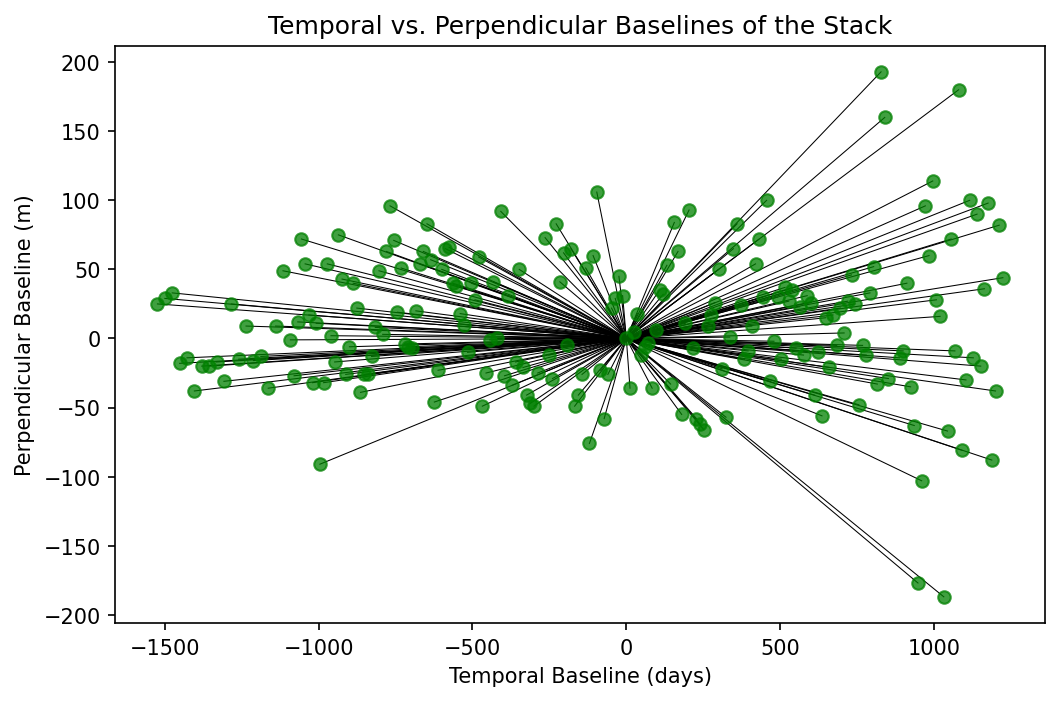

In [4]:
#%% Plot the network for the PSI interferometric pairs
plt.figure(figsize=(8,5), dpi=150)
for i in plt_pairs:
    t_m = master_frame.properties['temporalBaseline']
    p_m = master_frame.properties['perpendicularBaseline']
    
    plt.plot([i[2]-t_m, i[4]-t_m], [i[3]-p_m, i[5]-p_m], 'k-', linewidth=0.5)
    
plt.plot(tm_ls, pp_ls, 'go', alpha=0.75)
plt.xlabel('Temporal Baseline (days)')
plt.ylabel('Perpendicular Baseline (m)')
plt.title('Temporal vs. Perpendicular Baselines of the Stack')

In [ ]:
#%% Apply the one graph workflow to calculate the interferogram and the backgeocoding
#Open log file to write the processing status
log_file = log_folder + 'log_psi.txt'

# If the log file exists, remove it and create a new one
if exists(log_file):
    remove(log_file)

with open(log_file, 'w') as log:
    log.write('-----------------------------------------------\n')
    
for slave_pair in ifg_pairs:
    slave1 = slave_pair[0]
    slave2 = slave_pair[1]
    
    slave1_date = slave1.split('/')[-1][17:25]
    slave2_date = slave2.split('/')[-1][17:25]
    
    output_geo_folder = geo_folder + slave1_date + '-' + slave2_date + '/'
    output_ifg_folder = ifg_folder + slave1_date + '-' + slave2_date + '/'
    
    output_folder_list = [output_geo_folder, output_ifg_folder]
    
    output_ifg_dim = output_ifg_folder + slave1_date + '-' + slave2_date + '_Ifg.dim'
    output_ifg_data = output_ifg_dim.replace('.dim', '.data')
    
    output_geo_dim = output_geo_folder + slave1_date + '-' + slave2_date + '_Geo.dim'
    output_geo_data = output_geo_dim.replace('.dim', '.data')
    
    for i in output_folder_list:
        if not exists(i):
            mkdir(i)
    
    #Print the processing files to the log file        
    with open(log_file, 'a') as log:
            log.write('-----------------------------------------------\n')
            log.write("Slave 1: " + slave1 + '\n')
            log.write("Slave 2: " + slave2 + '\n')
            log.write('Merged Back-Geocoding file: ' + output_geo_dim + '\n')
            log.write('Interferogram file: ' + output_ifg_dim + '\n')
            log.write('---------------- Processing -------------------\n')  
    
    print('-----------------------------------------------')
    print("Slave 1: ", slave1)
    print("Slave 2: ", slave2)
    print('Merged Back-Geocoding file: ', output_geo_dim)
    print('Interferogram file: ', output_ifg_dim)
    print('---------------- Processing -------------------')
    
    with open(one_graph, 'r') as graph2read:
        graph = graph2read.read()
        graph = graph.replace('INPUTSLAVE1', slave1)
        graph = graph.replace('INPUTSLAVE2', slave2)
        graph = graph.replace('OUTPUTBGMRG', output_geo_dim)
        graph = graph.replace('OUTPUTIFGMLFLT', output_ifg_dim)
        
    with open(one_graph2run, 'w') as graph2write:
        graph2write.write(graph)
        
    # Check if the output_ifg_iw file exists and if not run the graph
    if not exists(output_ifg_dim) or not exists(output_geo_dim):
        proc_stat, message = rungraph(one_graph2run, GPT, CACHE, CPU, 
                             JVMemMax, 'Interferogram and Back-Geocoding')
        print(message)
        
        with open(log_file, 'a') as log:
            log.write(message)
            log.write('-----------------------------------------------\n')

        if proc_stat != 0:
            print('Removing output file')
            remove(output_geo_dim)
            rmtree(output_geo_data)
            remove(output_ifg_dim)
            rmtree(output_ifg_data)
            continue
        
    else:
        print(output_geo_dim + ': Back-Geocoding already exists')
        print(output_ifg_dim + ': Interferogram already exists')
        
        with open(log_file, 'a') as log:
            log.write(output_geo_dim + ': Back-Geocoding already exists' + '\n')
            log.write(output_ifg_dim + ': Interferogram already exists' + '\n')
            log.write('-----------------------------------------------\n')
print('------------ Process Finished -----------------')    

-----------------------------------------------
Slave 1:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SDV_20200128T155605_20200128T155633_031002_038F9D_FCD0.zip
Slave 2:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20151126T155542_20151126T155610_008777_00C835_5DF3.zip
Merged Back-Geocoding file:  /data/custom/DeepNL/insareg/snapwf_02/output/psi/01_geo/20200128-20151126/20200128-20151126_Geo.dim
Interferogram file:  /data/custom/DeepNL/insareg/snapwf_02/output/psi/02_ifg/20200128-20151126/20200128-20151126_Ifg.dim
---------------- Processing -------------------
